In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pylab as pl
import sklearn.cross_validation, sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction import DictVectorizer, FeatureHasher
import scipy.stats
import xgboost as xgb

%matplotlib inline
pd.set_option('display.mpl_style', 'default')
pl.rcParams['figure.figsize'] = (20, 10)

train = pd.read_csv('train.csv', low_memory=False)
test = pd.read_csv('test.csv', low_memory=False)
types = np.unique(train.TripType.values)
types_dictionary = {t: i for i, t in  enumerate(types)}

In [2]:
train = train[~pd.isnull(train.Upc)]
train = train[~pd.isnull(train.FinelineNumber)]
test = test[~pd.isnull(test.Upc)]
test = test[~pd.isnull(test.FinelineNumber)]


In [3]:
def at(l):
    return l.iloc[0]
def mklist(l):
    return list(l)

train = train.groupby('VisitNumber').agg({'TripType': at, 'Weekday': at, 'ScanCount': mklist, 
                                          'DepartmentDescription': at, 'FinelineNumber': mklist, 
                                          'Upc': mklist}).reset_index()
test = test.groupby('VisitNumber').agg({'Weekday': at, 'ScanCount': mklist, 'DepartmentDescription': at,
                                        'FinelineNumber': mklist, 'Upc': mklist}).reset_index()


In [4]:
def construct_features(data):
    data.Upc = data.Upc.map(lambda x: np.array(x, dtype=int))
    data.FinelineNumber = data.FinelineNumber.map(lambda x: np.array(x, dtype=int))
    
#     data['NumberOfReturned'] = data.ScanCount.map(lambda x: -sum([a for a in x if a < 0]))
    data['LogNumberOfReturned'] = data.ScanCount.map(lambda x: np.log(-sum([a for a in x if a < 0]) + 1))
    data['NumberOfPurchased'] = data.ScanCount.map(lambda x: sum([a for a in x if a > 0]))
    data['ModeScanCount'] = data.ScanCount.map(lambda x: scipy.stats.mode(x)[0][0])
    data['ModeUpc'] = data.Upc.map(lambda x: scipy.stats.mode(x)[0][0])
    data['ModeFinelineNumber'] = data.FinelineNumber.map(lambda x: scipy.stats.mode(x)[0][0])
    
    for i in range(0, 11):
        train['Upc_' + str(i)] = train.Upc.map(lambda x: scipy.stats.mode([a // 10**i % 10 for a in x])[0][0])
    return data

In [5]:
train = construct_features(train)
test = construct_features(test)

In [16]:
train.ix[train.TripType == 5, ['TripType', 'Upc', 'FinelineNumber', 'ScanCount', 
                               'LogNumberOfReturned', 'NumberOfPurchased']].iloc[:10]

,TripType,Upc,FinelineNumber,ScanCount,LogNumberOfReturned,NumberOfPurchased
58,5,"[63748004256, 63748006502, 68113118730]","[309, 312, 2561]","[2, 1, 1]",0,4
103,5,[68113129801],[2303],[1],0,1
139,5,"[38137116146, 3800059099, 3800059099, 61126913...","[3524, 5, 5, 3467, 3533, 4080]","[1, 1, 1, 1, 1, 1]",0,6
194,5,"[85303000202, 3927822010]","[4079, 2041]","[1, 1]",0,2
216,5,[68113111122],[905],[1],0,1
228,5,[83913800253],[509],[2],0,2
236,5,"[68113111128, 7007440701, 2430078106, 3400013410]","[701, 401, 2286, 125]","[1, 1, 1, 1]",0,4
317,5,"[4000047652, 7874206317, 68113173156, 63347200...","[115, 4602, 4602, 4601, 509, 1411]","[2, 1, 1, 1, 1, 1]",0,7
338,5,"[30169183402, 30169183302, 30149003916]","[4822, 4822, 2104]","[1, 1, 1]",0,3
342,5,"[7146434851, 85651600203, 68113106267, 7803537...","[7131, 7129, 403, 3601, 5701, 103]","[1, 1, 1, 1, 1, 1]",0,6


In [15]:
# sns.boxplot('TripType', 'NumberOfPurchased', data=train)


In [8]:
def get_prior_probabilities(data):
    prior_probabilities = np.zeros(len(types))
    prior_probabilities += np.array([len(data[data.TripType == trip_type]) for trip_type in types])
    prior_probabilities /= prior_probabilities.sum()
    return prior_probabilities

In [9]:
def construct_dummy_features(data, dummy_columns):
    data = pd.get_dummies(data, sparse=True, dummy_na=False, columns=dummy_columns)
    return data

In [10]:
data = train.append(test)
data = data[[col for col in data.columns if col not in ['Upc', 'ScanCount', 'FinelineNumber']]]
data = construct_dummy_features(data, ['Weekday', 'DepartmentDescription'])
train_dummies = data.iloc[:len(train)]
test_dummies = data.iloc[len(train):]
del data, test_dummies['TripType']
print(len(test_dummies.columns), 'features constructed')

92 features constructed


In [11]:
print('Memory usage of dataframe train_dummies is %3.2f Mb' % (train_dummies.memory_usage(index=True).sum()/(1024*1024)))
print('Memory usage of dataframe test_dummies is %3.2f Mb' % (test_dummies.memory_usage(index=True).sum()/(1024*1024)))

Memory usage of dataframe train_dummies is 15.10 Mb
Memory usage of dataframe test_dummies is 14.39 Mb


In [12]:
def fit_predict(train_array, train_labels, test_array, prior_probabilities=None, algorithm='rf', alpha=None, 
                plot_importance=True, feature_names=None):
    if algorithm == 'xgb':
        train_labels = np.array([types_dictionary[x] for x in train_labels])
        dtrain = xgb.DMatrix(train_array, train_labels)
        
        dtest = xgb.DMatrix(test_array)
        param = {
            'bst:eta':0.4, 'bst:max_depth':8, 'bst:colsample_bytree': 0.45, 'objective': 'multi:softprob',
            'eval_metric':'mlogloss', 'num_class':len(types) 
        }
        n_round = 40
        bst = xgb.train(param, dtrain, n_round)
        prediction_matrix = bst.predict(dtest)
        if plot_importance:
            xgb.plot_importance(bst)
    else:
        if algorithm == 'rf':
            clf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=1, max_features=0.2, n_jobs=-1)
        clf.fit(train_array, train_labels)
        prediction_matrix = clf.predict_proba(test_array)
        if plot_importance and feature_names:
            importances = clf.feature_importances_
            std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
            pl.title('Feature Importance')
            sorted_indices = np.argsort(importances)[::-1]
            for i, k in enumerate(sorted_indices):
                print('%2d (feature %2d):' % (i, k), feature_names[k], 'Value = %.5f' % importances[k])
#             print([feature_names[k] for k in sorted_indices])

            pl.bar(range(len(feature_names)), importances[sorted_indices], color='r',
                   yerr=std[sorted_indices], align='center')
            pl.xticks(range(len(feature_names)), sorted_indices)
            pl.xlim([-1, len(feature_names) + 1])
            
    if not prior_probabilities is None:
        coeff = 0.1
        prediction_matrix = (prediction_matrix + [prior_probabilities*coeff]*len(prediction_matrix))/(1. + coeff)
    return prediction_matrix

In [13]:
def train_and_score(train_dummies, grid_space=[0], algorithm='rf', plot_importance=True):
    if len(grid_space) > 1:
        alphas, scores = [], []
        min_alpha, min_score = 1., 10**5
    
    for alpha in grid_space:
        if len(grid_space) > 1:
            print('alpha =', alpha)
        y = train_dummies.TripType.values
        for train_indices, test_indices in sklearn.cross_validation.StratifiedShuffleSplit(y, n_iter=1, test_size=0.1):
            data_train = train_dummies.iloc[train_indices]
            data_test = train_dummies.iloc[test_indices]

    #         prior_probabilities = get_prior_probabilities(data_train)
            feature_names = [col for col in data_train.columns if col not in ['TripType', 'VisitNumber']]
            prediction_matrix = fit_predict(data_train[feature_names].values, 
                                            data_train.TripType.values, 
                                            data_test[[col for col in data_test.columns 
                                                       if col not in ['TripType', 'VisitNumber']]].values, 
                                            algorithm=algorithm, alpha=alpha, plot_importance=plot_importance, 
                                            feature_names=feature_names)

            prediction_matrix = np.delete(prediction_matrix, 7, axis=1)

            y_true = data_test.TripType.values

            mlogloss = sklearn.metrics.log_loss(y_true, prediction_matrix) 
            print('mlogloss =', mlogloss, end='\n\n')
            
            if len(grid_space) > 1:
                alphas.append(alpha)
                scores.append(mlogloss)
                if mlogloss <= min_score:
                    min_score = mlogloss
                    min_alpha = alpha
    if len(grid_space) > 1:
        return alphas, scores, min_alpha, min_score
    else:
        return mlogloss

##MAIN

 0 (feature  4): NumberOfPurchased Value = 0.21607
 1 (feature  3): ModeUpc Value = 0.07446
 2 (feature  2): ModeScanCount Value = 0.07302
 3 (feature  1): ModeFinelineNumber Value = 0.06975
 4 (feature 15): Upc_9 Value = 0.03365
 5 (feature 11): Upc_5 Value = 0.03278
 6 (feature  0): LogNumberOfReturned Value = 0.03081
 7 (feature 14): Upc_8 Value = 0.02872
 8 (feature  9): Upc_3 Value = 0.02591
 9 (feature  5): Upc_0 Value = 0.02558
10 (feature  8): Upc_2 Value = 0.02556
11 (feature 43): DepartmentDescription_FINANCIAL SERVICES Value = 0.02528
12 (feature 12): Upc_6 Value = 0.02524
13 (feature  6): Upc_1 Value = 0.02523
14 (feature  7): Upc_10 Value = 0.02401
15 (feature 13): Upc_7 Value = 0.02347
16 (feature 75): DepartmentDescription_PHARMACY OTC Value = 0.02173
17 (feature 10): Upc_4 Value = 0.02106
18 (feature 83): DepartmentDescription_SERVICE DELI Value = 0.01477
19 (feature 40): DepartmentDescription_DSD GROCERY Value = 0.01252
20 (feature 73): DepartmentDescription_PERSONAL C

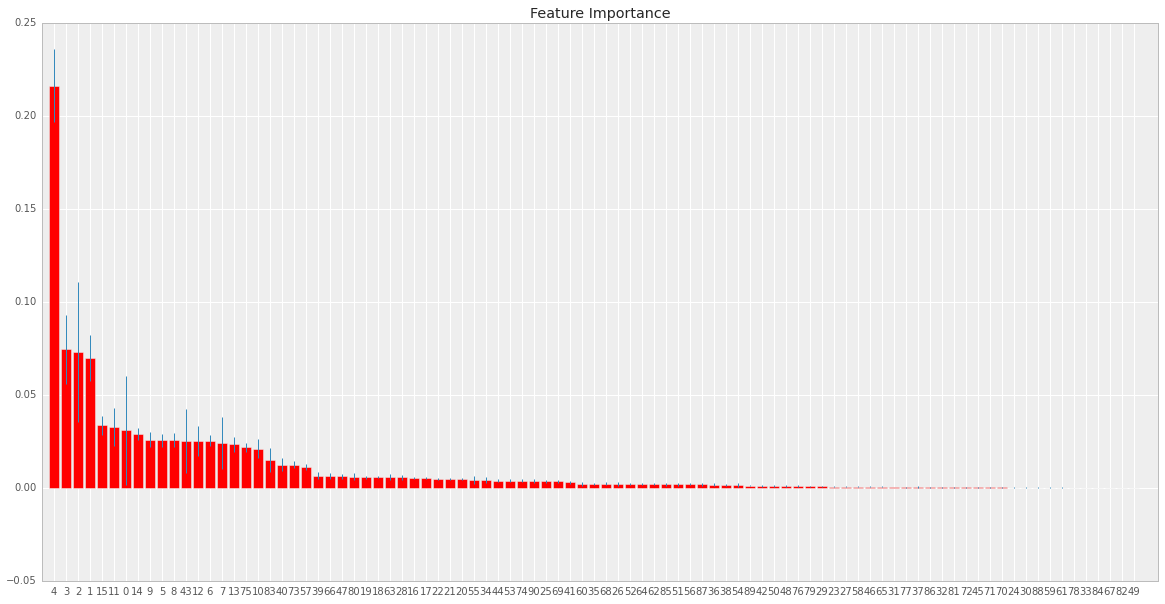

In [17]:
algorithms = ['rf', 'xgb']
algorithm = 'rf'

validation = True

if validation:
    
    compute_optimal = False
    if compute_optimal:
        grid_space = np.linspace(0.1, 0.9, 10)
        alphas, scores, min_alpha, min_score = train_and_score(train_dummies, grid_space=grid_space,
                                                               algorithm=algorithm, plot_importance=False)
        print('MIN ALPHA =', min_alpha, 'MIN_MLOGLOSS =', min_score)
        pl.plot(alphas, scores, 'r.--')
    else:
        mlogloss = train_and_score(train_dummies, algorithm=algorithm)
    
elif not validation:
#     prior_probabilities = get_prior_probabilities(train)
    prediction_matrix = fit_predict(train_dummies[[col for col in train_dummies.columns 
                                            if col not in ['TripType', 'VisitNumber']]].values, 
                                    train_dummies.TripType.values, 
                                    test_dummies[[col for col in test_dummies.columns if col not in ['VisitNumber']]].values, 
                                    algorithm=algorithm)
    
    prediction_df = pd.DataFrame(prediction_matrix, columns=['TripType_' + str(i) for i in types])
    prediction_df['VisitNumber'] = test_dummies.VisitNumber
    
    prediction_df = prediction_df[['VisitNumber'] + [x for x in prediction_df.columns if x != 'VisitNumber']]
    del prediction_matrix
    filename = 'prediction.csv'
    prediction_df.to_csv(filename, index=False)
    print(filename, 'was created')
    del prediction_df
    